# Методы приближения функции

## Введение

Данная работа посвящена методам интерполяции и проверке их практической точности и применимости.

## Методология

В качестве примера для построения интерполяции возьмем данные переписи населения России за 1959-2020 годы и, приблизив их разными методами, построим интерполянты и путем экстраполяции найдем численность населения в 2025 году. Интерполянты будем строить следующими методами:

1. Классическая полиномиальная интерполяция по Ньютону
2. Сплайн-интерполяция
3. Метод наименьших квадратов

In [124]:
import math
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

years = [1959, 1970, 1979, 1989, 2002, 2010, 2020]
pop = [117.5e6, 130.1e6, 137.6e6, 147.4e6, 145.2e6, 142.9e6, 146.0e6]

x = [y - years[0] for y in years]
x2025 = 2025 - years[0]

In [125]:
"""
Polynom
"""

def divided_differences(x, y):
    n = len(x)

    coef = [y[i] for i in range(n)]
    for j in range(1, n):
        for i in range(n-1, j-1, -1):
            coef[i] = (coef[i] - coef[i-1]) / (x[i] - x[i-j])
    return coef

def newton_poly_eval(coef, x_data, x):
    n = len(coef)
    result = coef[-1]
    for i in range(n-2, -1, -1):
        result = result * (x - x_data[i]) + coef[i]
    return result

coef_newton = divided_differences(x, pop)
newton_2025 = newton_poly_eval(coef_newton, x, x2025)

In [126]:
"""
Cubic spline
"""

def thomas_solve(a, b, c, d):
    a = np.asarray(a, dtype=float).copy()
    b = np.asarray(b, dtype=float).copy()
    c = np.asarray(c, dtype=float).copy()
    d = np.asarray(d, dtype=float).copy()
    n = b.size
    if not (a.size == n and c.size == n and d.size == n):
        raise ValueError("a, b, c, d должны иметь одинаковую длину")

    for i in range(1, n):
        if b[i - 1] == 0:
            raise ZeroDivisionError("Деление на ноль в прогонке")
        w = a[i] / b[i - 1]
        b[i] = b[i] - w * c[i - 1]
        d[i] = d[i] - w * d[i - 1]

    x = np.zeros(n, dtype=float)
    if b[-1] == 0:
        raise ZeroDivisionError("Деление на ноль в прогонке (в конце)")
    x[-1] = d[-1] / b[-1]
    for i in range(n - 2, -1, -1):
        x[i] = (d[i] - c[i] * x[i + 1]) / b[i]
    return x


def cubic_spline_moments(x, y):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    N = x.size
    if N != y.size:
        raise ValueError("x и y должны иметь одинаковую длину")
    if N < 2:
        raise ValueError("Нужно хотя бы 2 точки")
    if N == 2:
        return np.array([0.0, 0.0])
    h = x[1:] - x[:-1]
    if np.any(h == 0):
        raise ValueError("Узлы x должны быть различны")

    n = N - 2
    a = np.zeros(n, dtype=float)
    b = np.zeros(n, dtype=float)
    c = np.zeros(n, dtype=float)
    d = np.zeros(n, dtype=float)

    for i in range(1, N - 1):
        idx = i - 1
        hi_1 = h[i - 1]
        hi = h[i]
        a[idx] = hi_1
        b[idx] = 2 * (hi_1 + hi)
        c[idx] = hi
        d[idx] = 6 * ((y[i + 1] - y[i]) / hi - (y[i] - y[i - 1]) / hi_1)

    M_internal = thomas_solve(a, b, c, d)
    M = np.zeros(N, dtype=float)
    M[1:-1] = M_internal
    return M


def spline_eval(x_nodes, y_nodes, M, x_eval):
    x_nodes = np.asarray(x_nodes, dtype=float)
    y_nodes = np.asarray(y_nodes, dtype=float)
    M = np.asarray(M, dtype=float)
    x_eval = np.asarray(x_eval, dtype=float)
    N = x_nodes.size
    if not (y_nodes.size == N and M.size == N):
        raise ValueError("x_nodes, y_nodes, M должны иметь одинаковую длину")
    h = x_nodes[1:] - x_nodes[:-1]

    def eval_one(xp):
        if xp <= x_nodes[0]:
            k = 0
        elif xp >= x_nodes[-1]:
            k = N - 2
        else:
            k = np.searchsorted(x_nodes, xp) - 1
            if k < 0:
                k = 0
            elif k > N - 2:
                k = N - 2
        xk = x_nodes[k]
        xk1 = x_nodes[k + 1]
        hk = xk1 - xk
        if hk == 0:
            return y_nodes[k]
        A = (xk1 - xp) / hk
        B = (xp - xk) / hk
        val = (M[k] * (A**3) * hk**2 / 6.0 + M[k + 1] * (B**3) * hk**2 / 6.0 +
               (y_nodes[k] - M[k] * hk**2 / 6.0) * A +
               (y_nodes[k + 1] - M[k + 1] * hk**2 / 6.0) * B)
        return val

    vec = np.vectorize(eval_one, otypes=[float])
    return vec(x_eval)

m = cubic_spline_moments(x, pop)
spline_2025 = spline_eval(x, pop, m, x2025)

In [127]:
"""
МНК
"""

def solve_gauss(A, F, eps=1e-15):
    assert len(A) == len(F)
    for i in A:
        assert len(i) == len(F)
    n = len(A)

    # forward
    for i in range(n):
        for j in range(i+1, n):
            c = A[j][i] / A[i][i]
            for k in range(n):
                A[j][k] -= A[i][k] * c
            F[j] -= F[i] * c

    x = [0 for _ in range(n)]

    # reverse
    for i in range(n-1, -1, -1):
        s = F[i]
        for j in range(i+1, n):
            s -= x[j]*A[i][j]
        x[i] = s / A[i][i]

    return x

def design_matrix_polynomial(x, deg=2):
    x = np.asarray(x, dtype=float)
    n = x.size
    A = np.vander(x, N=deg + 1, increasing=True)
    return A

def least_squares_quad(x, y, deg=2):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if x.size != y.size:
        raise ValueError("x и y должны иметь одинаковую длину")
    if deg < 0 or int(deg) != deg:
        raise ValueError("deg должен быть неотрицательным целым")
    A = design_matrix_polynomial(x, deg)

    ATA = A.T @ A
    ATy = A.T @ y
    coeffs = solve_gauss(ATA, ATy)
    return coeffs

coef_ls = least_squares_quad(x, pop)
A = design_matrix_polynomial([x2025])
ls_2025 = (A @ coef_ls)[0]

In [128]:
"""
Результаты
"""

true_2025 = 146.2e6

print("Полином Ньютона:", newton_2025)
print("Кубический сплайн:", spline_2025)
print("МНК (квадрат.):", ls_2025)
print("Референсное значение:", true_2025)

Полином Ньютона: 135567332.73519892
Кубический сплайн: 148146518.65541637
МНК (квадрат.): 140954588.0734256
Референсное значение: 146200000.0


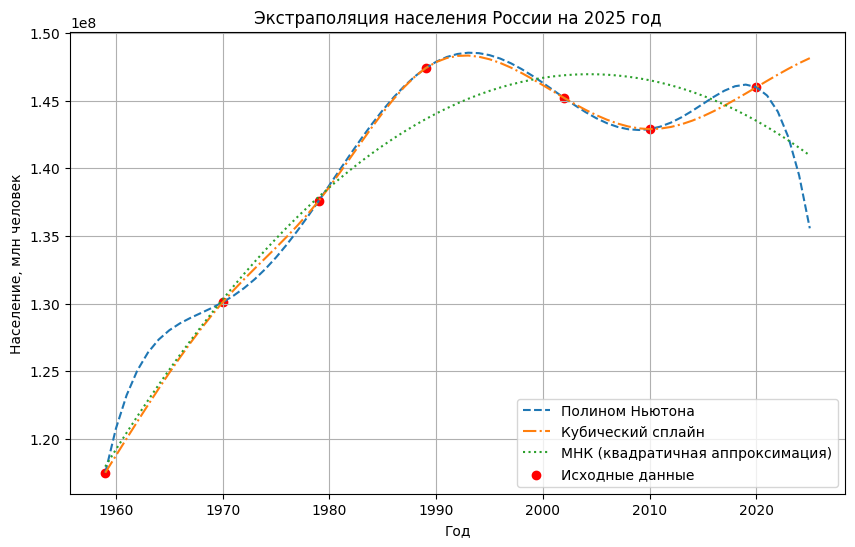

In [129]:
x_plot = [i for i in range(x[0], x2025+1)]
newton_plot = [newton_poly_eval(coef_newton, x, xi) for xi in x_plot]
spline_plot = [spline_eval(x, pop, m, xi) for xi in x_plot]
A = design_matrix_polynomial(x_plot)
ls_plot = A @ coef_ls

years_plot = [xi + years[0] for xi in x_plot]

plt.figure(figsize=(10,6))
plt.plot(years_plot, newton_plot, label='Полином Ньютона', linestyle='--')
plt.plot(years_plot, spline_plot, label='Кубический сплайн', linestyle='-.')
plt.plot(years_plot, ls_plot, label='МНК (квадратичная аппроксимация)', linestyle=':')
plt.scatter(years, pop, color='red', label='Исходные данные')

plt.xlabel('Год')
plt.ylabel('Население, млн человек')
plt.title('Экстраполяция населения России на 2025 год')
plt.legend()
plt.grid(True)
plt.show()